## Goal:

- We will build **task_mAIstro, a smart chatbot agent with long-term memory** that helps users manage their ToDo list.
- `task_mAIstro` can decide when and where to save information — either in a user profile (semantic memory) or as a collection of ToDo items.
- In addition to remembering facts, it will handle `procedural memory`, allowing users to update preferences for creating and managing ToDo tasks.
- The agent will combine reflection on past conversations with intelligent memory management to provide personalized and evolving assistance.

### Types of Memory:
- `Semantic Memory`:
  - Memory of `facts`, `concepts`, and `general knowledge`.
  - Usually structured, like user profiles or knowledge about the world.
- `Procedural Memory`:
  - `Memory of how to do things`, i.e., sequences of actions or procedures.
  - Focused on `skills`, `routines`, or `processes` rather than facts.
- `Long-Term Memory`:
  - Memory that persists `across sessions`, so the agent “remembers” past interactions.
  - Can include both `semantic` and `procedural` memories, but stored persistently.

In [1]:
from typing import TypedDict, Annotated, Literal, Optional
from IPython.display import display, Image
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage, merge_message_runs
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.config import RunnableConfig

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

from pydantic import BaseModel, Field

import uuid

from trustcall import create_extractor

from datetime import datetime

In [2]:
# Initialize the model
model = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

In [3]:
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

- https://docs.langchain.com/langsmith/run-data-format
  
#### `child_runs` Method:
The `child_runs` attribute provides access to all child runs in the trace hierarchy:

- `child_run_ids`: Array of UUIDs for all child runs (direct and nested descendants)
- `direct_child_run_ids`: Array of UUIDs for only the immediate children of this run

#### Other Key Run Attributes
Identification & Hierarchy:

- `id` - Unique identifier for the run
- `trace_id` - ID of the trace this run belongs to
- `parent_run_id` - ID of the parent run
- `dotted_order` - Hierarchical ordering string showing the run's position in the trace tree
  
#### Core Data:
- `inputs` - Input data provided to the run
- `outputs` - Output data generated by the run
- `name` - Name of the run
- `run_type` - Type (e.g., "llm", "chain", "tool")
- `start_time` / `end_time` - Execution timestamps
  
#### Metadata:
- `tags` - Array of strings for categorization
- `error` - Error message if the run failed
- `status` - Current status ("error", "pending", "success")

In [4]:
# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

In [5]:
# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [6]:
# Initialize the spy
spy = Spy()

In [7]:
# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [8]:
trustcall_extractor_see_all_tool_calls

RunnableBinding(bound=RunnableLambda(coerce_inputs)
| <langgraph.graph.state.CompiledStateGraph object at 0x70bd2d61add0>
| RunnableLambda(filter_state), kwargs={}, config={}, config_factories=[<function Runnable.with_listeners.<locals>.<lambda> at 0x70bd2d4b8820>])

In [9]:
# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [10]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (chatcmpl-tool-90787c3136820d57)
 Call ID: chatcmpl-tool-90787c3136820d57
  Args:
    content: User mentioned having a nice bike ride in San Francisco this morning.


In [11]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='User mentioned having a nice bike ride in San Francisco this morning.'


In [12]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'chatcmpl-tool-90787c3136820d57'}


In [13]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'User mentioned having a nice bike ride in San Francisco this morning.'})]

In [14]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

In [15]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'chatcmpl-tool-8d803cdbf6074a29', 'json_doc_id': '0'}


In [16]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (chatcmpl-tool-8d803cdbf6074a29)
 Call ID: chatcmpl-tool-8d803cdbf6074a29
  Args:
    content: User mentioned having a nice bike ride in San Francisco this morning. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!


In [17]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='User mentioned having a nice bike ride in San Francisco this morning. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!'


In [18]:
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': "1. replace the 'content' field with the new value that includes the information about going back to Japan this winter.",
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'User mentioned having a nice bike ride in San Francisco this morning. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!'}]},
   'id': 'chatcmpl-tool-8d803cdbf6074a29',
   'type': 'tool_call'}]]

In [19]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: 1. replace the 'content' field with the new value that includes the information about going back to Japan this winter.
Added content: User mentioned having a nice bike ride in San Francisco this morning. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!


## Creating an agent

Here, we'll implement something simple, a ReAct agent.
This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory:
- (a) Create or update a user profile with general user information

- (b) Add or update items in a ToDo list collection

- (c) Update its own instructions on how to update items to the ToDo list

In [20]:
# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

In [23]:
# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_length=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError



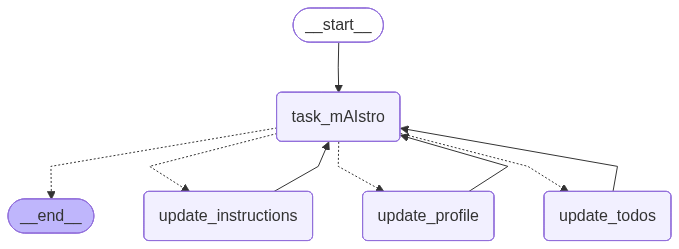

In [24]:
# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [25]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Lance. I live in SF with my wife. I have a 1 year old daughter.
================================== Ai Message ==================================

<think>
Okay, the user introduced himself as Lance, mentioned he lives in SF with his wife and has a 1-year-old daughter. I need to update the user profile with this information. The function to use is UpdateMemory with type 'user'. Let me structure the parameters properly. The user_profile should include his name, location, marital status, and daughter's age. I'll make sure to call the tool correctly.
</think>
Tool Calls:
  UpdateMemory (chatcmpl-tool-b79cf1d853d083ea)
 Call ID: chatcmpl-tool-b79cf1d853d083ea
  Args:
    update_type: user
    user_profile: {'name': 'Lance', 'location': 'SF', 'marital_status': 'married', 'daughter_age': 1}
================================= Tool Message =================================

updated profile
===============

In [26]:
# User input for a ToDo
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================

<think>
Okay, the user mentioned that his wife asked him to book swim lessons for their baby. Let me check the existing information. The user's profile says he has a 1-year-old daughter. So, the baby is his daughter.

I need to add this task to his ToDo list. The instructions say to update the ToDo list if tasks are mentioned. The task here is "book swim lessons for the baby." I should phrase it clearly. Maybe "Book swim lessons for 1-year-old daughter" to be specific.

No preferences for the ToDo list have been specified, so I can add it directly. Use the UpdateMemory tool with type 'todo' and the new task. Don't need to mention updating the instructions since there's no preference given. Confirm the addition by telling the user the task was added to the list.
</think>
Too

In [27]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================

<think>
Okay, the user wants me to include specific local businesses or vendors when creating or updating ToDo items. Let me see how to handle this.

First, the user's previous message was about booking swim lessons for their baby. I added a ToDo item with general solutions like contacting the local pool or checking the community center. Now, they're asking to include specific local businesses. 

So, I need to adjust the ToDo item to mention actual vendors. But wait, do I have information about local businesses in SF? The user mentioned they live in SF, so I should think of specific pools or community centers there. For example, maybe the Aquatic Park in SF or the Rec and Park Department. Also, certified swim instructors in SF could be from pl

In [29]:
# Check for updated instructions
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

In [30]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================

<think>
Okay, the user mentioned they need to fix a jammed electric Yale lock on the door. Let me start by recalling the previous interactions. The user's name is Lance, lives in SF with his wife and a 1-year-old daughter. The existing todo list has a task about booking swim lessons for the baby. The user also provided instructions to include specific local businesses when creating or updating todo items.

First, I need to determine if this new task about the Yale lock should be added to the todo list. The user hasn't mentioned anything about the lock before, so it's a new task. The instructions specify to include local businesses, so I should think of possible local vendors or services in SF that handle lock repairs. 

Yale locks are a specific brand, so maybe there a